In [2]:
import os
import config
import platform
v1, v2, v3 = config.spark_env(platform.node())
os.environ['SPARK_VERSION'] = v1
os.environ['JAVA_HOME'] = v2
os.environ['SPARK_HOME'] = v3
import findspark
import pyspark
from pyspark.sql import SparkSession
findspark.init()
spark = SparkSession.builder.appName("emissionsdataframe").getOrCreate()
from sqlalchemy import create_engine, insert
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import MetaData, update, Table
from sqlalchemy.orm import Session
from sqlalchemy.orm import sessionmaker
from sqlalchemy.exc import SQLAlchemyError
import pandas as pd
from pyspark.sql.types import IntegerType,BooleanType,DateType
from pyspark.sql.functions import col
from pyspark.sql import Row
from pyspark.sql.functions import array, col, explode, lit, struct, log
from pyspark.sql import DataFrame
from typing import Iterable
import numpy as np
import tensorflow as tf
import keras.metrics
import pyspark.sql.functions as F
import math
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pystan
import fbprophet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from fbprophet import Prophet
from sklearn.model_selection import train_test_split
import scipy.stats as st
from pyspark.sql import Row
from sqlalchemy.orm import Session, sessionmaker
from sqlalchemy import MetaData, Table

rds_string = config.rds_string
engine = create_engine(f'postgresql://{rds_string}')
conn = engine.connect()
metadata = MetaData(engine)

In [3]:
def melt(
        df: DataFrame, 
        id_vars: Iterable[str], value_vars: Iterable[str], 
        var_name: str="variable", value_name: str="value") -> DataFrame:
    """Convert :class:`DataFrame` from wide to long format."""

    # Create array<struct<variable: str, value: ...>>
    _vars_and_vals = array(*(
        struct(lit(c).alias(var_name), col(c).alias(value_name)) 
        for c in value_vars))

    # Add to the DataFrame and explode
    _tmp = df.withColumn("_vars_and_vals", explode(_vars_and_vals))

    cols = id_vars + [
            col("_vars_and_vals")[x].alias(x) for x in [var_name, value_name]]
    return _tmp.select(*cols)


def min_int(df,column):
    arr = np.array(df.select(column).collect())
    y_l = []
    for i in arr:
        y_l.append(int(i[0]))
    min_ = min(y_l)
    max_ = max(y_l)
    return (min_, max_)  


def sql_to_spark_gdp(country):
    table_var = Table("gdp_data", metadata, autoload=True, autoload_with=engine)
    Session = sessionmaker()
    Session.configure(bind=engine)
    session = Session()
    query = session.query(table_var).filter(table_var.c.Country == country).all()
    steve = table_var.metadata.tables["gdp_data"].columns.keys()
    query_list = []
    for i in query:
        q_len = len(i)
        temp_dict = {}
        for j in range(q_len):
            key = steve[j]
            value = i[j]
            if value == None:
                value = float(0)
            temp_dict[key] = value
            if j == (q_len - 1):
                query_list.append(temp_dict)
    df = spark.createDataFrame(Row(**x) for x in query_list)
    gdp_col = df.columns
    gdp_col2 = gdp_col[2:]
    gdp_static_cols = gdp_col[:2]
    df = melt(df, id_vars=gdp_static_cols, value_vars=gdp_col2)
    df = df.withColumn("variable",df.variable.cast('int'))
    df = df.withColumnRenamed("variable","year")
    df = df.withColumnRenamed("value","gdp")
    df = df.withColumnRenamed("Country","country")
    df = df.select(['country','year','gdp'])
    return df

def sql_to_spark_emissions(country):
    table_var = Table("global_emissions", metadata, autoload=True, autoload_with=engine)
    Session = sessionmaker()
    Session.configure(bind=engine)
    session = Session()
    query = session.query(table_var).filter(table_var.c.Entity == country).all()
    steve = table_var.metadata.tables["global_emissions"].columns.keys()
    query_list = []
    for i in query:
        q_len = len(i)
        temp_dict = {}
        for j in range(q_len):
            key = steve[j]
            value = i[j]
            if value == None:
                value = float(0)
            temp_dict[key] = value
            if j == (q_len - 1):
                query_list.append(temp_dict)
    df = spark.createDataFrame(Row(**x) for x in query_list)
    df = df.withColumnRenamed("Entity","country")
    df = df.withColumnRenamed("Year","year")
    return df

def sql_to_spark_trade(country):
    table_var = Table("global_trade", metadata, autoload=True, autoload_with=engine)
    Session = sessionmaker()
    Session.configure(bind=engine)
    session = Session()
    query = session.query(table_var).filter(table_var.c.country_or_area == country).all()
    steve = table_var.metadata.tables["global_trade"].columns.keys()
    c_list = []
    for i in query:
        q_len = len(i)
        if i[0] == country:
            temp_dict = {}
            for j in range(q_len):
                key = steve[j]
                value = i[j]
                if value == None:
                    value = float(0)
                temp_dict[key] = value
                if j == (q_len - 1):
                    c_list.append(temp_dict)
    df = spark.createDataFrame(Row(**x) for x in c_list)
    df = df.withColumn("year",df.year.cast('int'))
    df = df.withColumnRenamed("country_or_area","country")
    df_export = df.filter(df['flow'] == "Export")
    df_import = df.filter(df['flow'] == "Import")
    return (df_export, df_import)




def merged_df(country):
    if country == "United States":
        export_df, import_df = sql_to_spark_trade("USA")
    else:
        export_df, import_df = sql_to_spark_trade(country)
    export_df_min, export_df_max = min_int(export_df, 'year')
    import_df_min, import_df_max = min_int(import_df, 'year')

    gdp_spark = sql_to_spark_gdp(country)
    gdp_spark_min, gdp_spark_max = min_int(gdp_spark, "year")

    emissions_spark = sql_to_spark_emissions(country)
    emissions_min, emissions_max = min_int(emissions_spark, 'year')

    years_df = pd.DataFrame([{"min":export_df_min, "max":export_df_max},
    {"min":import_df_min, "max":import_df_max},
    {"min":gdp_spark_min, "max":gdp_spark_max},
    {"min":emissions_min, "max":emissions_max}])

    lower_bound = years_df['min'].max()
    upper_bound = years_df['max'].min()

    gdp_spark = gdp_spark.filter(gdp_spark["year"] >= lower_bound)
    gdp_spark = gdp_spark.filter(gdp_spark["year"] <= upper_bound)
    emissions_spark = emissions_spark.filter(emissions_spark["year"] >= lower_bound)
    emissions_spark = emissions_spark.filter(emissions_spark["year"] <= upper_bound)
    import_df = import_df.filter(import_df["year"] >= lower_bound)
    import_df = import_df.filter(import_df["year"] <= upper_bound)
    export_df = export_df.filter(export_df["year"] >= lower_bound)
    export_df = export_df.filter(export_df["year"] <= upper_bound)
    merged_df = gdp_spark.join(emissions_spark, gdp_spark.year == emissions_spark.year, 'outer') \
    .select(gdp_spark.country ,gdp_spark.year,gdp_spark.gdp, emissions_spark.annual_co2_emissions_tonnes) \
    .distinct()
    merged_df = merged_df.orderBy(merged_df.year.asc())
    import_sum = import_df.groupBy('year').sum()
    import_sum = import_sum.orderBy(import_sum.year.asc())
    import_sum = import_sum.withColumnRenamed("sum(trade_usd)","import_trade_sum_usd")
    import_sum = import_sum.withColumnRenamed("sum(weight_kg)","import_weight_sum_kg")
    import_sum = import_sum.withColumnRenamed("sum(quantity)","import_quantity_sum")
    export_sum = export_df.groupBy('year').sum()
    export_sum = export_sum.orderBy(export_sum.year.asc())
    export_sum = export_sum.withColumnRenamed("sum(trade_usd)","export_trade_sum_usd")
    export_sum = export_sum.withColumnRenamed("sum(weight_kg)","export_weight_sum_kg")
    export_sum = export_sum.withColumnRenamed("sum(quantity)","export_quantity_sum")
    merged_df = merged_df.join(import_sum, merged_df.year == import_sum.year, 'outer') \
    .select(merged_df.country ,merged_df.year,merged_df.gdp, merged_df.annual_co2_emissions_tonnes,
        import_sum['import_trade_sum_usd'],import_sum['import_weight_sum_kg'],import_sum['import_quantity_sum']) \
    .distinct()
    merged_df = merged_df.orderBy(merged_df.year.asc())
    merged_df = merged_df.join(export_sum, merged_df.year == export_sum.year, 'outer') \
    .select(merged_df.country ,merged_df.year,merged_df.gdp, merged_df.annual_co2_emissions_tonnes,
        merged_df['import_trade_sum_usd'],merged_df['import_weight_sum_kg'],merged_df['import_quantity_sum'],
        export_sum['export_trade_sum_usd'],export_sum['export_weight_sum_kg'],export_sum['export_quantity_sum']
        ) \
    .distinct()
    merged_df = merged_df.orderBy(merged_df.year.asc())
    merged_df = merged_df.withColumn("annual_co2_emissions_tonnes_log", F.log10(col("annual_co2_emissions_tonnes")))
    merged_df = merged_df.withColumn("import_trade_sum_usd_log", F.log10(col("import_trade_sum_usd")))
    merged_df = merged_df.withColumn("import_weight_sum_kg_log", F.log10(col("import_weight_sum_kg")))
    merged_df = merged_df.withColumn("import_quantity_sum_log", F.log10(col("import_quantity_sum")))
    merged_df = merged_df.withColumn("export_trade_sum_usd_log", F.log10(col("export_trade_sum_usd")))
    merged_df = merged_df.withColumn("export_weight_sum_kg_log", F.log10(col("export_weight_sum_kg")))
    merged_df = merged_df.withColumn("export_quantity_sum_log", F.log10(col("export_quantity_sum")))
    merged_df = merged_df.select('country',
                    'year',
                    'gdp',
                    'annual_co2_emissions_tonnes_log',
                    'import_trade_sum_usd_log',
                    'import_weight_sum_kg_log',
                    'import_quantity_sum_log',
                    'export_trade_sum_usd_log',
                    'export_weight_sum_kg_log',
                    'export_quantity_sum_log')


    columns = merged_df.columns
   
    return (merged_df, columns)

def check_list():
    table_var = Table("gdp_data", metadata, autoload=True, autoload_with=engine)
    Session = sessionmaker()
    Session.configure(bind=engine)
    session = Session()
    q = session.query(table_var).distinct(table_var.c.Country).all()
    checker = []
    for row in q:
        checker.append(row[0])
    return checker

    
checker = check_list()
checker


['Afghanistan',
 'Albania',
 'Algeria',
 'Angola',
 'Antigua and Barbuda',
 'Arab World',
 'Argentina',
 'Armenia',
 'Aruba',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas, The',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bermuda',
 'Bhutan',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Botswana',
 'Brazil',
 'British Virgin Islands',
 'Brunei Darussalam',
 'Bulgaria',
 'Burkina Faso',
 'Burundi',
 'Cabo Verde',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Caribbean small states',
 'Cayman Islands',
 'Central African Republic',
 'Central Europe and the Baltics',
 'Chad',
 'Chile',
 'China',
 'Colombia',
 'Comoros',
 'Congo, Dem. Rep.',
 'Congo, Rep.',
 'Costa Rica',
 "Cote d'Ivoire",
 'Croatia',
 'Curacao',
 'Cyprus',
 'Czech Republic',
 'Denmark',
 'Djibouti',
 'Dominica',
 'Dominican Republic',
 'Early-demographic dividend',
 'East Asia & Pacific',
 'East Asia & Pacific (IDA & IBRD countries)',
 'East Asia & Pacific (excluding high income)',
 'E

In [4]:
def country_list():
    holder = False
    countries = []
    while holder == False:
        country = input(f'What country would you like to add? ')
        try:
            if country in checker:
                if country not in countries:
                    countries.append(country)
        except:
            print("not a valid country")
        switch = input(f'Would you like to add another? y/n ') 
        if switch == 'n':
            holder = True
    return countries
countries = country_list()

What country would you like to add? United States
Would you like to add another? y/n y
What country would you like to add? China
Would you like to add another? y/n y
What country would you like to add? India
Would you like to add another? y/n y
What country would you like to add? Germany
Would you like to add another? y/n y
What country would you like to add? Argentina
Would you like to add another? y/n n


In [5]:
def df_maker(arr):
    c_dict = {}
    for i in arr:
        temp_dict = {}
        df, cols = merged_df(i)
        c_dict[i] = {'df': df}
        c_dict['cols'] = cols
    steve = len(arr)    
    df = c_dict[arr[0]]['df']
    for i in range(steve - 1):
        column = arr[i+1]
        df2 = c_dict[column]['df']
        df = df.union(df2)
    c_dict['union'] = {'df':df}
    return c_dict

diction = df_maker(countries)

def make_models(diction):
    col_len = len(diction['cols'][2:])
    dict_ = {}
    for i in range(col_len):
        tempz_dict = {}
        temp_dict = {}
        colz = diction['cols'][2:]
        y = colz[i]
        colz.remove(colz[i])
        x = colz

        arr = np.array(diction['union']['df'].select(
         x[0],
         x[1],
         x[2],
         x[3],
         x[4],
         x[5],
         x[6]) \
        .collect(),dtype = 'float')    
        arr2 = np.array(diction['union']['df'].select(y).collect(),dtype = 'float')
        tempz_dict = {'x':arr,'y':arr2}
        X_train, X_test, y_train, y_test = train_test_split(arr, arr2, test_size=0.2)
        X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.2)
        tempz_dict['train'] = [X_train,y_train]
        tempz_dict['test'] = [X_test,y_test]
        tempz_dict['val'] = [X_val,y_val]
        X_scaler = StandardScaler().fit(X_train)
        tempz_dict['scaler'] = X_scaler
        X_train_scaled = X_scaler.transform(X_train)
        X_test_scaled = X_scaler.transform(X_test)
        X_val_scaled = X_scaler.transform(X_val)
        model = Sequential()
        model.add(Dense(units=100, activation='relu', input_dim=7))
        model.add(Dense(units=100, activation='relu'))
        model.add(Dense(units=100, activation='ReLU'))
        model.add(Dense(units=100, activation='PReLU'))
        model.add(Dense(units=100, activation='swish'))
        model.add(Dense(units=1, activation='linear'))
        METRICS = [
              keras.metrics.MeanAbsoluteError(name='mean_absolute_error'),
              keras.metrics.MeanSquaredError(name='mean_squared_error')
        ]


        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='mse', 
            verbose=1,
            patience=10,
            mode='max',
            restore_best_weights=True)

        EPOCHS = 100    
        model.compile(optimizer='adam',
                  loss='mse',
                  metrics=METRICS)

        model_history = model.fit(
        X_train_scaled,
        y_train,
        epochs=EPOCHS,
        validation_data=(X_test_scaled, y_test)
        )
        tempz_dict['model'] = model
        diction[y] = tempz_dict
    return diction

diction = make_models(diction)

def spark_to_prophet(df, column):
    arr = np.array(df.collect())
    df = pd.DataFrame(arr, columns = column)
    ds_len = len(df)
    dates = []
    for i in range(ds_len):
        year = str(int(df['year'][i]))
        year = year + "-01-01"
        dates.append(year)
    df['year'] = dates
    return df
def make_prophet_model(df,periods):
    m = Prophet()
    m.fit(df)
    future = m.make_future_dataframe(periods=periods, freq='Y')
    forecast = m.predict(future)
    return (forecast, m)



Epoch 1/100
4/4 [==============================] - 2s 51ms/step - loss: 630103552.0000 - mean_absolute_error: 18991.4824 - mean_squared_error: 630103552.0000 - val_loss: 722487104.0000 - val_mean_absolute_error: 22043.1738 - val_mean_squared_error: 722487104.0000
Epoch 2/100
4/4 [==============================] - 0s 9ms/step - loss: 630090688.0000 - mean_absolute_error: 18991.1328 - mean_squared_error: 630090688.0000 - val_loss: 722465216.0000 - val_mean_absolute_error: 22042.6523 - val_mean_squared_error: 722465216.0000
Epoch 3/100
4/4 [==============================] - 0s 9ms/step - loss: 630070528.0000 - mean_absolute_error: 18990.5859 - mean_squared_error: 630070528.0000 - val_loss: 722424704.0000 - val_mean_absolute_error: 22041.6914 - val_mean_squared_error: 722424704.0000
Epoch 4/100
4/4 [==============================] - 0s 10ms/step - loss: 630028736.0000 - mean_absolute_error: 18989.5508 - mean_squared_error: 630028736.0000 - val_loss: 722351616.0000 - val_mean_absolute_error

4/4 [==============================] - 0s 9ms/step - loss: 38975312.0000 - mean_absolute_error: 5002.0166 - mean_squared_error: 38975312.0000 - val_loss: 26177358.0000 - val_mean_absolute_error: 3935.9851 - val_mean_squared_error: 26177358.0000
Epoch 33/100
4/4 [==============================] - 0s 9ms/step - loss: 36674788.0000 - mean_absolute_error: 4804.6929 - mean_squared_error: 36674788.0000 - val_loss: 24694628.0000 - val_mean_absolute_error: 3823.7102 - val_mean_squared_error: 24694628.0000
Epoch 34/100
4/4 [==============================] - 0s 9ms/step - loss: 34589164.0000 - mean_absolute_error: 4614.2373 - mean_squared_error: 34589164.0000 - val_loss: 22819212.0000 - val_mean_absolute_error: 3626.4719 - val_mean_squared_error: 22819212.0000
Epoch 35/100
4/4 [==============================] - 0s 9ms/step - loss: 32844340.0000 - mean_absolute_error: 4437.1235 - mean_squared_error: 32844340.0000 - val_loss: 21958208.0000 - val_mean_absolute_error: 3516.7695 - val_mean_squared_er

Epoch 64/100
4/4 [==============================] - 0s 11ms/step - loss: 14374739.0000 - mean_absolute_error: 2499.7053 - mean_squared_error: 14374739.0000 - val_loss: 9225477.0000 - val_mean_absolute_error: 2041.5852 - val_mean_squared_error: 9225477.0000
Epoch 65/100
4/4 [==============================] - 0s 9ms/step - loss: 14289443.0000 - mean_absolute_error: 2486.7605 - mean_squared_error: 14289443.0000 - val_loss: 9105067.0000 - val_mean_absolute_error: 2049.8015 - val_mean_squared_error: 9105067.0000
Epoch 66/100
4/4 [==============================] - 0s 9ms/step - loss: 14124090.0000 - mean_absolute_error: 2458.9622 - mean_squared_error: 14124090.0000 - val_loss: 9787059.0000 - val_mean_absolute_error: 2153.1692 - val_mean_squared_error: 9787059.0000
Epoch 67/100
4/4 [==============================] - 0s 9ms/step - loss: 13827686.0000 - mean_absolute_error: 2423.6536 - mean_squared_error: 13827686.0000 - val_loss: 9223656.0000 - val_mean_absolute_error: 2102.8169 - val_mean_squ

Epoch 96/100
4/4 [==============================] - 0s 9ms/step - loss: 11074199.0000 - mean_absolute_error: 2128.4365 - mean_squared_error: 11074199.0000 - val_loss: 10318670.0000 - val_mean_absolute_error: 2103.6562 - val_mean_squared_error: 10318670.0000
Epoch 97/100
4/4 [==============================] - 0s 9ms/step - loss: 11034303.0000 - mean_absolute_error: 2105.4204 - mean_squared_error: 11034303.0000 - val_loss: 9655166.0000 - val_mean_absolute_error: 2015.6653 - val_mean_squared_error: 9655166.0000
Epoch 98/100
4/4 [==============================] - 0s 9ms/step - loss: 11062729.0000 - mean_absolute_error: 2096.8354 - mean_squared_error: 11062729.0000 - val_loss: 9685880.0000 - val_mean_absolute_error: 2021.1113 - val_mean_squared_error: 9685880.0000
Epoch 99/100
4/4 [==============================] - 0s 9ms/step - loss: 10977075.0000 - mean_absolute_error: 2082.3052 - mean_squared_error: 10977075.0000 - val_loss: 10399369.0000 - val_mean_absolute_error: 2123.3208 - val_mean_s

Epoch 32/100
4/4 [==============================] - 0s 8ms/step - loss: 0.3934 - mean_absolute_error: 0.4973 - mean_squared_error: 0.3934 - val_loss: 0.4224 - val_mean_absolute_error: 0.5230 - val_mean_squared_error: 0.4224
Epoch 33/100
4/4 [==============================] - 0s 8ms/step - loss: 0.3570 - mean_absolute_error: 0.4704 - mean_squared_error: 0.3570 - val_loss: 0.2934 - val_mean_absolute_error: 0.4524 - val_mean_squared_error: 0.2934
Epoch 34/100
4/4 [==============================] - 0s 8ms/step - loss: 0.3661 - mean_absolute_error: 0.4669 - mean_squared_error: 0.3661 - val_loss: 0.2858 - val_mean_absolute_error: 0.4457 - val_mean_squared_error: 0.2858
Epoch 35/100
4/4 [==============================] - 0s 9ms/step - loss: 0.3024 - mean_absolute_error: 0.4359 - mean_squared_error: 0.3024 - val_loss: 0.3919 - val_mean_absolute_error: 0.5192 - val_mean_squared_error: 0.3919
Epoch 36/100
4/4 [==============================] - 0s 8ms/step - loss: 0.3059 - mean_absolute_error: 0.

4/4 [==============================] - 0s 9ms/step - loss: 0.0459 - mean_absolute_error: 0.1555 - mean_squared_error: 0.0459 - val_loss: 0.1166 - val_mean_absolute_error: 0.2625 - val_mean_squared_error: 0.1166
Epoch 69/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0441 - mean_absolute_error: 0.1473 - mean_squared_error: 0.0441 - val_loss: 0.1080 - val_mean_absolute_error: 0.2578 - val_mean_squared_error: 0.1080
Epoch 70/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0382 - mean_absolute_error: 0.1351 - mean_squared_error: 0.0382 - val_loss: 0.1152 - val_mean_absolute_error: 0.2847 - val_mean_squared_error: 0.1152
Epoch 71/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0502 - mean_absolute_error: 0.1612 - mean_squared_error: 0.0502 - val_loss: 0.1058 - val_mean_absolute_error: 0.2713 - val_mean_squared_error: 0.1058
Epoch 72/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0405 - mean_absolute_error: 0.1522 - mean_s

4/4 [==============================] - 0s 8ms/step - loss: 68.2462 - mean_absolute_error: 8.0893 - mean_squared_error: 68.2462 - val_loss: 42.0965 - val_mean_absolute_error: 6.2658 - val_mean_squared_error: 42.0965
Epoch 5/100
4/4 [==============================] - 0s 9ms/step - loss: 29.1539 - mean_absolute_error: 4.8017 - mean_squared_error: 29.1539 - val_loss: 11.0538 - val_mean_absolute_error: 2.7608 - val_mean_squared_error: 11.0538
Epoch 6/100
4/4 [==============================] - 0s 9ms/step - loss: 20.8733 - mean_absolute_error: 3.8819 - mean_squared_error: 20.8733 - val_loss: 11.8701 - val_mean_absolute_error: 3.0152 - val_mean_squared_error: 11.8701
Epoch 7/100
4/4 [==============================] - 0s 9ms/step - loss: 18.4342 - mean_absolute_error: 3.6408 - mean_squared_error: 18.4342 - val_loss: 7.7886 - val_mean_absolute_error: 2.1870 - val_mean_squared_error: 7.7886
Epoch 8/100
4/4 [==============================] - 0s 9ms/step - loss: 9.4198 - mean_absolute_error: 2.589

4/4 [==============================] - 0s 8ms/step - loss: 0.3481 - mean_absolute_error: 0.3746 - mean_squared_error: 0.3481 - val_loss: 0.2336 - val_mean_absolute_error: 0.3849 - val_mean_squared_error: 0.2336
Epoch 41/100
4/4 [==============================] - 0s 8ms/step - loss: 0.3264 - mean_absolute_error: 0.3736 - mean_squared_error: 0.3264 - val_loss: 0.3157 - val_mean_absolute_error: 0.4532 - val_mean_squared_error: 0.3157
Epoch 42/100
4/4 [==============================] - 0s 9ms/step - loss: 0.2867 - mean_absolute_error: 0.3767 - mean_squared_error: 0.2867 - val_loss: 0.2039 - val_mean_absolute_error: 0.3548 - val_mean_squared_error: 0.2039
Epoch 43/100
4/4 [==============================] - 0s 8ms/step - loss: 0.2477 - mean_absolute_error: 0.3507 - mean_squared_error: 0.2477 - val_loss: 0.1955 - val_mean_absolute_error: 0.3537 - val_mean_squared_error: 0.1955
Epoch 44/100
4/4 [==============================] - 0s 8ms/step - loss: 0.2336 - mean_absolute_error: 0.3521 - mean_s

Epoch 77/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0478 - mean_absolute_error: 0.1505 - mean_squared_error: 0.0478 - val_loss: 0.0484 - val_mean_absolute_error: 0.1865 - val_mean_squared_error: 0.0484
Epoch 78/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0493 - mean_absolute_error: 0.1625 - mean_squared_error: 0.0493 - val_loss: 0.0549 - val_mean_absolute_error: 0.1958 - val_mean_squared_error: 0.0549
Epoch 79/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0448 - mean_absolute_error: 0.1508 - mean_squared_error: 0.0448 - val_loss: 0.0458 - val_mean_absolute_error: 0.1721 - val_mean_squared_error: 0.0458
Epoch 80/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0437 - mean_absolute_error: 0.1539 - mean_squared_error: 0.0437 - val_loss: 0.0616 - val_mean_absolute_error: 0.2132 - val_mean_squared_error: 0.0616
Epoch 81/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0415 - mean_absolute_error: 0.

4/4 [==============================] - 0s 9ms/step - loss: 3.0557 - mean_absolute_error: 1.4839 - mean_squared_error: 3.0557 - val_loss: 4.1042 - val_mean_absolute_error: 1.7501 - val_mean_squared_error: 4.1042
Epoch 14/100
4/4 [==============================] - 0s 8ms/step - loss: 2.4119 - mean_absolute_error: 1.2925 - mean_squared_error: 2.4119 - val_loss: 4.1333 - val_mean_absolute_error: 1.7966 - val_mean_squared_error: 4.1333
Epoch 15/100
4/4 [==============================] - 0s 8ms/step - loss: 2.1972 - mean_absolute_error: 1.2148 - mean_squared_error: 2.1972 - val_loss: 3.3363 - val_mean_absolute_error: 1.5906 - val_mean_squared_error: 3.3363
Epoch 16/100
4/4 [==============================] - 0s 8ms/step - loss: 1.7652 - mean_absolute_error: 1.1086 - mean_squared_error: 1.7652 - val_loss: 2.2364 - val_mean_absolute_error: 1.3027 - val_mean_squared_error: 2.2364
Epoch 17/100
4/4 [==============================] - 0s 8ms/step - loss: 1.4811 - mean_absolute_error: 1.0796 - mean_s

Epoch 50/100
4/4 [==============================] - 0s 8ms/step - loss: 0.1175 - mean_absolute_error: 0.2499 - mean_squared_error: 0.1175 - val_loss: 0.1173 - val_mean_absolute_error: 0.2589 - val_mean_squared_error: 0.1173
Epoch 51/100
4/4 [==============================] - 0s 9ms/step - loss: 0.1243 - mean_absolute_error: 0.2708 - mean_squared_error: 0.1243 - val_loss: 0.1607 - val_mean_absolute_error: 0.3010 - val_mean_squared_error: 0.1607
Epoch 52/100
4/4 [==============================] - 0s 8ms/step - loss: 0.1122 - mean_absolute_error: 0.2540 - mean_squared_error: 0.1122 - val_loss: 0.2058 - val_mean_absolute_error: 0.3482 - val_mean_squared_error: 0.2058
Epoch 53/100
4/4 [==============================] - 0s 8ms/step - loss: 0.1063 - mean_absolute_error: 0.2403 - mean_squared_error: 0.1063 - val_loss: 0.1238 - val_mean_absolute_error: 0.2552 - val_mean_squared_error: 0.1238
Epoch 54/100
4/4 [==============================] - 0s 8ms/step - loss: 0.1018 - mean_absolute_error: 0.

4/4 [==============================] - 0s 8ms/step - loss: 0.0215 - mean_absolute_error: 0.1097 - mean_squared_error: 0.0215 - val_loss: 0.0403 - val_mean_absolute_error: 0.1519 - val_mean_squared_error: 0.0403
Epoch 87/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0196 - mean_absolute_error: 0.1055 - mean_squared_error: 0.0196 - val_loss: 0.0313 - val_mean_absolute_error: 0.1414 - val_mean_squared_error: 0.0313
Epoch 88/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0213 - mean_absolute_error: 0.1094 - mean_squared_error: 0.0213 - val_loss: 0.0415 - val_mean_absolute_error: 0.1531 - val_mean_squared_error: 0.0415
Epoch 89/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0204 - mean_absolute_error: 0.1086 - mean_squared_error: 0.0204 - val_loss: 0.0409 - val_mean_absolute_error: 0.1551 - val_mean_squared_error: 0.0409
Epoch 90/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0214 - mean_absolute_error: 0.1111 - mean_s

4/4 [==============================] - 0s 10ms/step - loss: 0.7732 - mean_absolute_error: 0.6764 - mean_squared_error: 0.7732 - val_loss: 0.4943 - val_mean_absolute_error: 0.6060 - val_mean_squared_error: 0.4943
Epoch 23/100
4/4 [==============================] - 0s 10ms/step - loss: 0.7080 - mean_absolute_error: 0.6568 - mean_squared_error: 0.7080 - val_loss: 0.5222 - val_mean_absolute_error: 0.6496 - val_mean_squared_error: 0.5222
Epoch 24/100
4/4 [==============================] - 0s 10ms/step - loss: 0.6312 - mean_absolute_error: 0.6204 - mean_squared_error: 0.6312 - val_loss: 0.6165 - val_mean_absolute_error: 0.7335 - val_mean_squared_error: 0.6165
Epoch 25/100
4/4 [==============================] - 0s 9ms/step - loss: 0.6269 - mean_absolute_error: 0.6198 - mean_squared_error: 0.6269 - val_loss: 0.4119 - val_mean_absolute_error: 0.5855 - val_mean_squared_error: 0.4119
Epoch 26/100
4/4 [==============================] - 0s 10ms/step - loss: 0.6037 - mean_absolute_error: 0.5856 - me

4/4 [==============================] - 0s 9ms/step - loss: 0.0740 - mean_absolute_error: 0.2074 - mean_squared_error: 0.0740 - val_loss: 0.1880 - val_mean_absolute_error: 0.3680 - val_mean_squared_error: 0.1880
Epoch 59/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0863 - mean_absolute_error: 0.2271 - mean_squared_error: 0.0863 - val_loss: 0.1590 - val_mean_absolute_error: 0.3286 - val_mean_squared_error: 0.1590
Epoch 60/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0770 - mean_absolute_error: 0.2135 - mean_squared_error: 0.0770 - val_loss: 0.1802 - val_mean_absolute_error: 0.3422 - val_mean_squared_error: 0.1802
Epoch 61/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0847 - mean_absolute_error: 0.2431 - mean_squared_error: 0.0847 - val_loss: 0.1952 - val_mean_absolute_error: 0.3660 - val_mean_squared_error: 0.1952
Epoch 62/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0788 - mean_absolute_error: 0.2222 - mean

4/4 [==============================] - 0s 10ms/step - loss: 0.0330 - mean_absolute_error: 0.1439 - mean_squared_error: 0.0330 - val_loss: 0.1334 - val_mean_absolute_error: 0.3032 - val_mean_squared_error: 0.1334
Epoch 95/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0304 - mean_absolute_error: 0.1317 - mean_squared_error: 0.0304 - val_loss: 0.1268 - val_mean_absolute_error: 0.2939 - val_mean_squared_error: 0.1268
Epoch 96/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0297 - mean_absolute_error: 0.1342 - mean_squared_error: 0.0297 - val_loss: 0.1334 - val_mean_absolute_error: 0.2886 - val_mean_squared_error: 0.1334
Epoch 97/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0260 - mean_absolute_error: 0.1252 - mean_squared_error: 0.0260 - val_loss: 0.1340 - val_mean_absolute_error: 0.2839 - val_mean_squared_error: 0.1340
Epoch 98/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0295 - mean_absolute_error: 0.1307 - mean

4/4 [==============================] - 0s 9ms/step - loss: 0.7821 - mean_absolute_error: 0.6611 - mean_squared_error: 0.7821 - val_loss: 0.4461 - val_mean_absolute_error: 0.5522 - val_mean_squared_error: 0.4461
Epoch 31/100
4/4 [==============================] - 0s 9ms/step - loss: 0.7124 - mean_absolute_error: 0.6376 - mean_squared_error: 0.7124 - val_loss: 0.4476 - val_mean_absolute_error: 0.5391 - val_mean_squared_error: 0.4476
Epoch 32/100
4/4 [==============================] - 0s 9ms/step - loss: 0.6556 - mean_absolute_error: 0.6095 - mean_squared_error: 0.6556 - val_loss: 0.4424 - val_mean_absolute_error: 0.5427 - val_mean_squared_error: 0.4424
Epoch 33/100
4/4 [==============================] - 0s 9ms/step - loss: 0.6108 - mean_absolute_error: 0.5791 - mean_squared_error: 0.6108 - val_loss: 0.4020 - val_mean_absolute_error: 0.5139 - val_mean_squared_error: 0.4020
Epoch 34/100
4/4 [==============================] - 0s 9ms/step - loss: 0.5316 - mean_absolute_error: 0.5386 - mean_s

4/4 [==============================] - 0s 10ms/step - loss: 0.0439 - mean_absolute_error: 0.1552 - mean_squared_error: 0.0439 - val_loss: 0.1422 - val_mean_absolute_error: 0.2670 - val_mean_squared_error: 0.1422
Epoch 67/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0472 - mean_absolute_error: 0.1644 - mean_squared_error: 0.0472 - val_loss: 0.1385 - val_mean_absolute_error: 0.2751 - val_mean_squared_error: 0.1385
Epoch 68/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0444 - mean_absolute_error: 0.1613 - mean_squared_error: 0.0444 - val_loss: 0.1377 - val_mean_absolute_error: 0.2623 - val_mean_squared_error: 0.1377
Epoch 69/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0404 - mean_absolute_error: 0.1526 - mean_squared_error: 0.0404 - val_loss: 0.1353 - val_mean_absolute_error: 0.2509 - val_mean_squared_error: 0.1353
Epoch 70/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0399 - mean_absolute_error: 0.1481 - me

4/4 [==============================] - 0s 10ms/step - loss: 114.1089 - mean_absolute_error: 10.6709 - mean_squared_error: 114.1089 - val_loss: 108.0041 - val_mean_absolute_error: 10.3722 - val_mean_squared_error: 108.0041
Epoch 3/100
4/4 [==============================] - 0s 10ms/step - loss: 98.9245 - mean_absolute_error: 9.9232 - mean_squared_error: 98.9245 - val_loss: 87.8848 - val_mean_absolute_error: 9.3168 - val_mean_squared_error: 87.8848
Epoch 4/100
4/4 [==============================] - 0s 10ms/step - loss: 72.6181 - mean_absolute_error: 8.4267 - mean_squared_error: 72.6181 - val_loss: 55.7896 - val_mean_absolute_error: 7.2328 - val_mean_squared_error: 55.7896
Epoch 5/100
4/4 [==============================] - 0s 9ms/step - loss: 37.0057 - mean_absolute_error: 5.6873 - mean_squared_error: 37.0057 - val_loss: 22.3323 - val_mean_absolute_error: 4.3113 - val_mean_squared_error: 22.3323
Epoch 6/100
4/4 [==============================] - 0s 9ms/step - loss: 15.9431 - mean_absolute_

4/4 [==============================] - 0s 9ms/step - loss: 0.5074 - mean_absolute_error: 0.5469 - mean_squared_error: 0.5074 - val_loss: 0.6910 - val_mean_absolute_error: 0.6813 - val_mean_squared_error: 0.6910
Epoch 39/100
4/4 [==============================] - 0s 9ms/step - loss: 0.5142 - mean_absolute_error: 0.5524 - mean_squared_error: 0.5142 - val_loss: 0.8719 - val_mean_absolute_error: 0.7535 - val_mean_squared_error: 0.8719
Epoch 40/100
4/4 [==============================] - 0s 10ms/step - loss: 0.4698 - mean_absolute_error: 0.5285 - mean_squared_error: 0.4698 - val_loss: 0.6222 - val_mean_absolute_error: 0.6115 - val_mean_squared_error: 0.6222
Epoch 41/100
4/4 [==============================] - 0s 10ms/step - loss: 0.4434 - mean_absolute_error: 0.5187 - mean_squared_error: 0.4434 - val_loss: 0.5238 - val_mean_absolute_error: 0.5459 - val_mean_squared_error: 0.5238
Epoch 42/100
4/4 [==============================] - 0s 10ms/step - loss: 0.4042 - mean_absolute_error: 0.4829 - mea

4/4 [==============================] - 0s 10ms/step - loss: 0.0611 - mean_absolute_error: 0.1806 - mean_squared_error: 0.0611 - val_loss: 0.2257 - val_mean_absolute_error: 0.2801 - val_mean_squared_error: 0.2257
Epoch 75/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0569 - mean_absolute_error: 0.1727 - mean_squared_error: 0.0569 - val_loss: 0.2024 - val_mean_absolute_error: 0.2672 - val_mean_squared_error: 0.2024
Epoch 76/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0560 - mean_absolute_error: 0.1746 - mean_squared_error: 0.0560 - val_loss: 0.1733 - val_mean_absolute_error: 0.2459 - val_mean_squared_error: 0.1733
Epoch 77/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0601 - mean_absolute_error: 0.1810 - mean_squared_error: 0.0601 - val_loss: 0.1970 - val_mean_absolute_error: 0.2768 - val_mean_squared_error: 0.1970
Epoch 78/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0524 - mean_absolute_error: 0.1691 - mea

4/4 [==============================] - 0s 9ms/step - loss: 8.8757 - mean_absolute_error: 2.5501 - mean_squared_error: 8.8757 - val_loss: 5.4301 - val_mean_absolute_error: 1.9744 - val_mean_squared_error: 5.4301
Epoch 11/100
4/4 [==============================] - 0s 9ms/step - loss: 5.8377 - mean_absolute_error: 2.0207 - mean_squared_error: 5.8377 - val_loss: 3.6187 - val_mean_absolute_error: 1.4528 - val_mean_squared_error: 3.6187
Epoch 12/100
4/4 [==============================] - 0s 10ms/step - loss: 5.0407 - mean_absolute_error: 1.8891 - mean_squared_error: 5.0407 - val_loss: 3.7106 - val_mean_absolute_error: 1.4765 - val_mean_squared_error: 3.7106
Epoch 13/100
4/4 [==============================] - 0s 9ms/step - loss: 4.6218 - mean_absolute_error: 1.7833 - mean_squared_error: 4.6218 - val_loss: 2.7682 - val_mean_absolute_error: 1.3593 - val_mean_squared_error: 2.7682
Epoch 14/100
4/4 [==============================] - 0s 9ms/step - loss: 3.7668 - mean_absolute_error: 1.6060 - mean_

4/4 [==============================] - 0s 10ms/step - loss: 0.1372 - mean_absolute_error: 0.2763 - mean_squared_error: 0.1372 - val_loss: 0.6409 - val_mean_absolute_error: 0.5224 - val_mean_squared_error: 0.6409
Epoch 47/100
4/4 [==============================] - 0s 10ms/step - loss: 0.1221 - mean_absolute_error: 0.2567 - mean_squared_error: 0.1221 - val_loss: 0.4714 - val_mean_absolute_error: 0.4287 - val_mean_squared_error: 0.4714
Epoch 48/100
4/4 [==============================] - 0s 9ms/step - loss: 0.1104 - mean_absolute_error: 0.2564 - mean_squared_error: 0.1104 - val_loss: 0.4373 - val_mean_absolute_error: 0.4041 - val_mean_squared_error: 0.4373
Epoch 49/100
4/4 [==============================] - 0s 10ms/step - loss: 0.1005 - mean_absolute_error: 0.2448 - mean_squared_error: 0.1005 - val_loss: 0.4744 - val_mean_absolute_error: 0.4324 - val_mean_squared_error: 0.4744
Epoch 50/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0922 - mean_absolute_error: 0.2277 - me

4/4 [==============================] - 0s 9ms/step - loss: 0.0411 - mean_absolute_error: 0.1604 - mean_squared_error: 0.0411 - val_loss: 0.4411 - val_mean_absolute_error: 0.3376 - val_mean_squared_error: 0.4411
Epoch 83/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0380 - mean_absolute_error: 0.1520 - mean_squared_error: 0.0380 - val_loss: 0.5304 - val_mean_absolute_error: 0.3970 - val_mean_squared_error: 0.5304
Epoch 84/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0360 - mean_absolute_error: 0.1447 - mean_squared_error: 0.0360 - val_loss: 0.4633 - val_mean_absolute_error: 0.3717 - val_mean_squared_error: 0.4633
Epoch 85/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0410 - mean_absolute_error: 0.1592 - mean_squared_error: 0.0410 - val_loss: 0.4982 - val_mean_absolute_error: 0.3757 - val_mean_squared_error: 0.4982
Epoch 86/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0334 - mean_absolute_error: 0.1421 - mea

select the number of years in the future you would like to predict5


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run

['United States', 'China', 'India', 'Germany', 'Argentina']
pick your country to studyGermany
['yhat', 'yhat_lower', 'yhat_upper']
Pick your boundry lineyhat
['gdp', 'annual_co2_emissions_tonnes_log', 'import_trade_sum_usd_log', 'import_weight_sum_kg_log', 'import_quantity_sum_log', 'export_trade_sum_usd_log', 'export_weight_sum_kg_log', 'export_quantity_sum_log']
Pick your y value to observeannual_co2_emissions_tonnes_log

The correlation between both factors is 0.82
The slope is 0.11409805453811174


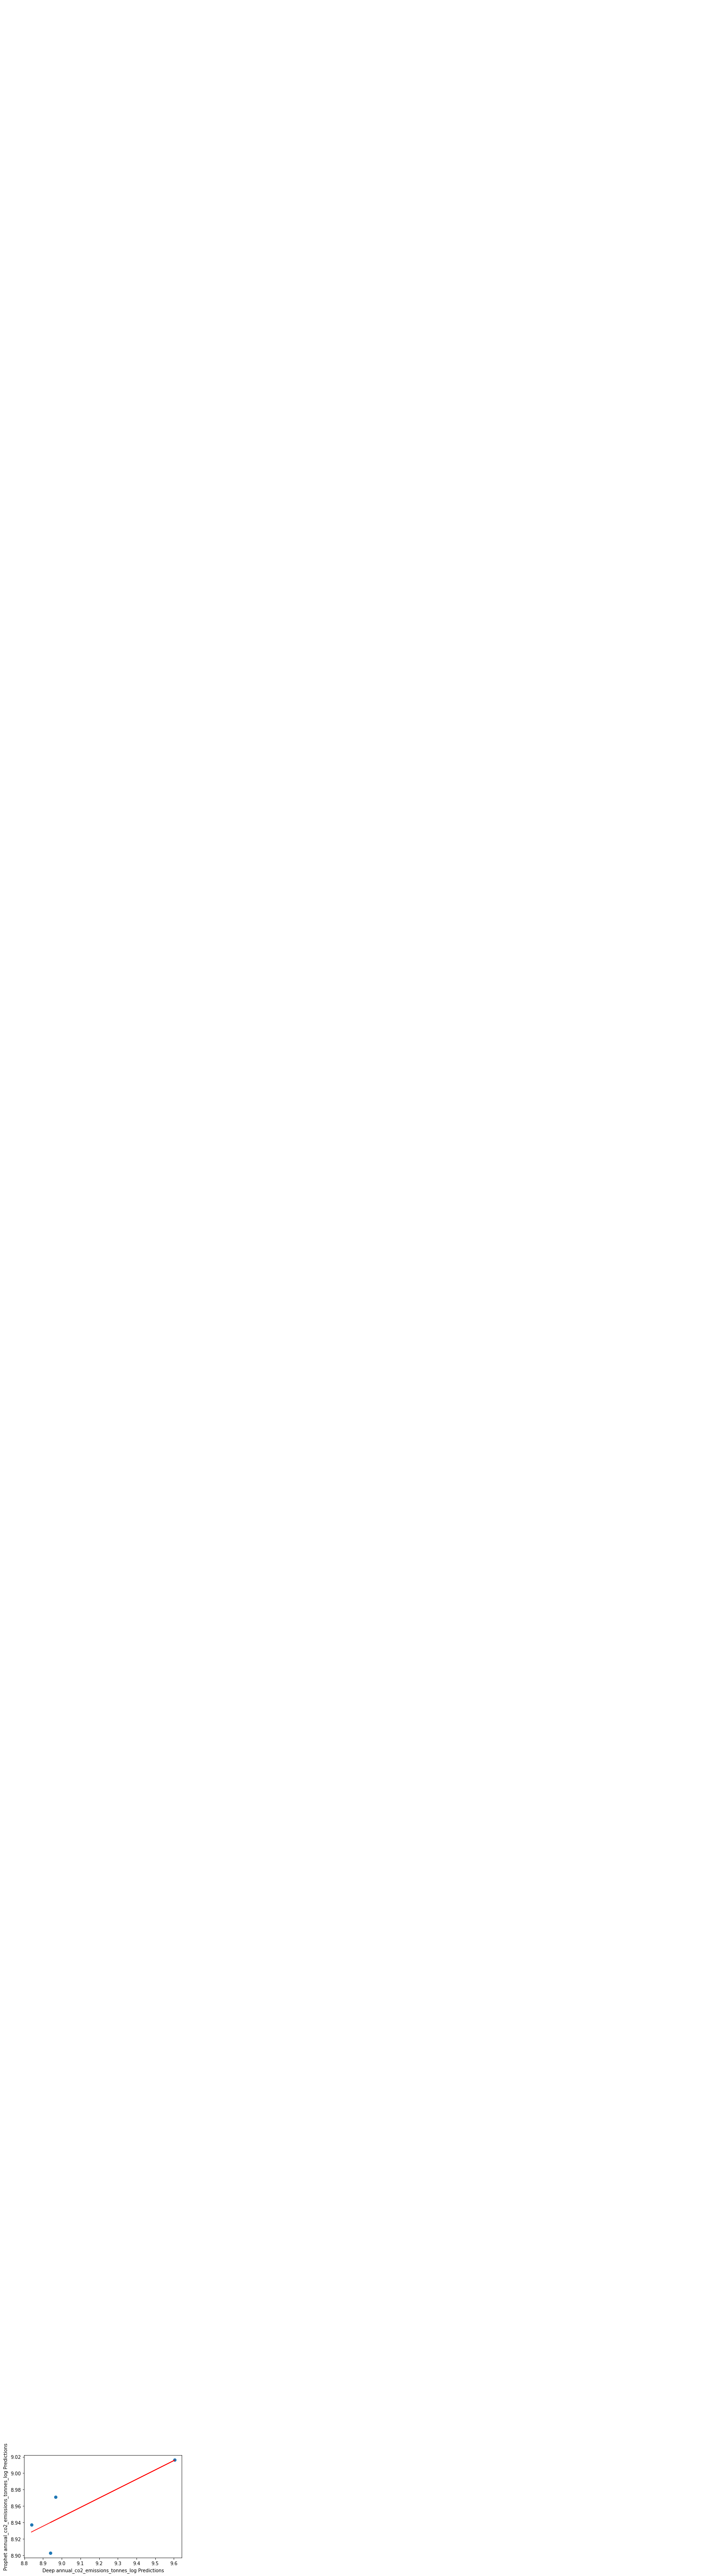

In [6]:
def proph(diction,periods):
    dict__= {}
    
    for i in countries:
        dict_ = {}
        df = diction[i]['df']
        cols = df.columns
        df = spark_to_prophet(df,cols)
        test_cols = cols[2:]
        yhat_df = pd.DataFrame()
        yhat_lower_df = pd.DataFrame()
        yhat_upper_df = pd.DataFrame()
        country_l = []
        for j in test_cols:
            future_df = pd.DataFrame()
            future_df['ds'] = df['year']
            future_df['y'] = df[j]
            df2, m = make_prophet_model(future_df,periods)
            dict_[j] = {'model':m,'future':df2}
        dict__[i] = dict_
    diction['prophet'] = dict__
    return diction
periods = int(input(f'select the number of years in the future you would like to predict'))

diction = proph(diction,periods)

def hats(diction):
    dictionary = {}

    for c in countries:
        rows = diction[c]['df'].count()
        columns = diction['cols'][2:]
        lenz = len(columns)
        df_y = pd.DataFrame()
        df_low = pd.DataFrame()
        df_up = pd.DataFrame()
        c_list = []
        for l in columns:

            try:
                df_y['country']
            except:
                holdz = len(diction['prophet'][c][l]['future'])
                fin_hold = holdz - rows
                for r in range(holdz):
                    c_list.append(c)                
                df_y['country'] =c_list
                df_y['year'] = diction['prophet'][c][l]['future']['ds']
                df_low['country'] =c_list
                df_low['year'] = diction['prophet'][c][l]['future']['ds']
                df_up['country'] =c_list
                df_up['year'] = diction['prophet'][c][l]['future']['ds']
            df_y[l] = diction['prophet'][c][l]['future']['yhat']
            df_low[l] = diction['prophet'][c][l]['future']['yhat']
            df_up[l] = diction['prophet'][c][l]['future']['yhat']

        dictionary[c] = {'yhat':df_y, 'yhat_lower':df_low, 'yhat_upper':df_up}
    diction['prophet_predictions'] = dictionary       
    return diction

diction = hats(diction)

def dl_preds(diction):    
    lenz = diction['India']['df'].count()
    dictionary = {}
    for c in countries:

        model_yhat_df = pd.DataFrame()
        model_yhat_lower_df = pd.DataFrame()
        model_yhat_upper_df = pd.DataFrame()
        yhat = diction['prophet_predictions'][c]['yhat'][lenz:]
        yhat_lower = diction['prophet_predictions'][c]['yhat_lower'][lenz:]
        yhat_upper = diction['prophet_predictions'][c]['yhat_upper'][lenz:]
        model_yhat_df['country'] = yhat['country']
        model_yhat_df['year'] = yhat['year']
        model_yhat_lower_df['country'] = yhat_lower['country']
        model_yhat_lower_df['year'] = yhat_lower['year']
        model_yhat_upper_df['country'] = yhat_upper['country']
        model_yhat_upper_df['year'] = yhat_upper['year']
        diction['prophet_predictions'][c]
        columns = diction['cols'][2:]
        for i in columns:
            col = diction['cols'][2:]
            X_scaler =  diction[i]['scaler']
            model = diction[i]['model']
            col.remove(i)
            x_yhat = yhat[col]
            x_yhat_lower = yhat_lower[col]
            x_yhat_upper = yhat_upper[col]

            x_yhat_norm = X_scaler.transform(x_yhat)
            x_yhat_lower_norm = X_scaler.transform(x_yhat_lower)
            x_yhat_upper_norm = X_scaler.transform(x_yhat_upper)

            model_yhat_df[i] = model.predict(x_yhat_norm)
            model_yhat_lower_df[i] = model.predict(x_yhat_lower_norm)
            model_yhat_upper_df[i] = model.predict(x_yhat_upper_norm)
        dictionary[c] = {'dl_yhat':model_yhat_df, 'dl_yhat_lower':model_yhat_lower_df, 'dl_yhat_upper':model_yhat_upper_df}
    diction['dl_prediction_dfs'] = dictionary
    return diction

diction = dl_preds(diction)


def plotter(diction,country,boundry,y_val):
    dl_boundry = "dl_" + boundry
    holder = len(diction['dl_prediction_dfs'][country][dl_boundry])
    y = diction['prophet'][country][y_val]['future'][boundry][-holder:]    
    x = diction['dl_prediction_dfs'][country][dl_boundry][y_val]
    correlation = st.pearsonr(x,y)
    (slope, intercept, rvalue, pvalue, stderr) = st.linregress(x, y)
    regress_values = x * slope + intercept
    line_eq = "y = " + str(round(slope,8)) + "x + " + str(round(intercept,2))
    plt.scatter(x,y)
    plt.plot(x,regress_values,"r-")
    plt.annotate(line_eq,(12,12),fontsize=15,color="red")
    plt.xlabel(f'Deep {y_val} Predictions')
    plt.ylabel(f'Prophet {y_val} Predictions')
    print(f"The correlation between both factors is {round(correlation[0],2)}")
    print(f'The slope is {slope}')
    plt.show()
    return 
    
def c_pick():
    print(countries)
    country = input(f'pick your country to study')
    return country

def b_pick():   
    print(['yhat', 'yhat_lower', 'yhat_upper'])
    boundry = input(f'Pick your boundry line')
    return boundry

def y_pick():    
    print(diction['cols'][2:])
    y_ = input(f'Pick your y value to observe')
    return y_

country = c_pick()
boundry = b_pick()
y_val = y_pick()
print("")

plotter(diction,country,boundry,y_val)    